#Comparing Classifiers
Comparing the performance of k-nearest neighbors, logistic regression, decision trees, and support vector machines

Analyzing marketing data from a Portugese bank

In [2692]:

import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)



In [2693]:
#import csv files
bank_data = pd.read_csv('Data/bank-full.csv', delimiter=';')

#show bank_data as table
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [2694]:
bank_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [2695]:
#list distinct values of each column
for column in bank_data.columns:
    if bank_data[column].dtype == object:
        print(column, bank_data[column].unique())

job ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital ['married' 'single' 'divorced']
education ['tertiary' 'secondary' 'unknown' 'primary']
default ['no' 'yes']
housing ['yes' 'no']
loan ['no' 'yes']
contact ['unknown' 'cellular' 'telephone']
month ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome ['unknown' 'failure' 'other' 'success']
y ['no' 'yes']


In [2696]:
#import csv files
bank_data_sample = pd.read_csv('Data/bank.csv', delimiter=';')

#show bank_data as table
bank_data_sample.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [2697]:
#create a new dataframe to store the numeric based data
bank_clean = bank_data.copy()
#replace the categorical variables with the numerical values
bank_clean['job'] = LabelEncoder().fit_transform(bank_data['job'])
bank_clean['marital'] = LabelEncoder().fit_transform(bank_data['marital'])
bank_clean['education'] = LabelEncoder().fit_transform(bank_data['education'])
bank_clean['default'] = LabelEncoder().fit_transform(bank_data['default'])
bank_clean['housing'] = LabelEncoder().fit_transform(bank_data['housing'])
bank_clean['loan'] = LabelEncoder().fit_transform(bank_data['loan'])
bank_clean['contact'] = LabelEncoder().fit_transform(bank_data['contact'])
bank_clean['month'] = LabelEncoder().fit_transform(bank_data['month'])
bank_clean['poutcome'] = LabelEncoder().fit_transform(bank_data['poutcome'])
bank_clean['y'] = LabelEncoder().fit_transform(bank_data['y'])

bank_clean.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0


In [2698]:

#save the columns as a dictionary list and make the values the unique values
clean_columns = {}
for column in bank_clean.columns:
    if column not in ['age', 'balance', 'duration', 'day', 'pdays', 'campaign', 'previous']:
        clean_columns[column] = bank_clean[column].unique()

#showing the dictionary list
for key, value in clean_columns.items():
    print(key, value)



job [ 4  9  2  1 11  5  0  7  6 10  3  8]
marital [1 2 0]
education [2 1 3 0]
default [0 1]
housing [1 0]
loan [0 1]
contact [2 0 1]
month [ 8  6  5  1 10  9  2  4  3  7  0 11]
poutcome [3 0 1 2]
y [0 1]


In [2699]:
#create a new dataframe to store the numerica based sample data
bank_clean_sample = bank_data_sample.copy()

#replace the categorical variables with the numerical values
bank_clean_sample['job'] = LabelEncoder().fit_transform(bank_data_sample['job'])
bank_clean_sample['marital'] = LabelEncoder().fit_transform(bank_data_sample['marital'])
bank_clean_sample['education'] = LabelEncoder().fit_transform(bank_data_sample['education'])
bank_clean_sample['default'] = LabelEncoder().fit_transform(bank_data_sample['default'])
bank_clean_sample['housing'] = LabelEncoder().fit_transform(bank_data_sample['housing'])
bank_clean_sample['loan'] = LabelEncoder().fit_transform(bank_data_sample['loan'])
bank_clean_sample['contact'] = LabelEncoder().fit_transform(bank_data_sample['contact'])
bank_clean_sample['month'] = LabelEncoder().fit_transform(bank_data_sample['month'])
bank_clean_sample['poutcome'] = LabelEncoder().fit_transform(bank_data_sample['poutcome'])
bank_clean_sample['y'] = LabelEncoder().fit_transform(bank_data_sample['y'])

bank_clean.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0


In [2700]:
#create a correlation matrix with the bank_clean data
corr = bank_clean.corr()
#plot the correlation matrix
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True)
plt.show()


#Loan success by marketing campaign outcome

The definitions of the marketing campaign outcomes were undefined, other than the supply of the four values: unknown, failure, other, and success.  While there is a strong correlation between the successful loans (individuals who accepted the terms of deposit), there were customers who accepted the loan terms without being classified as part of a successful campaigns.

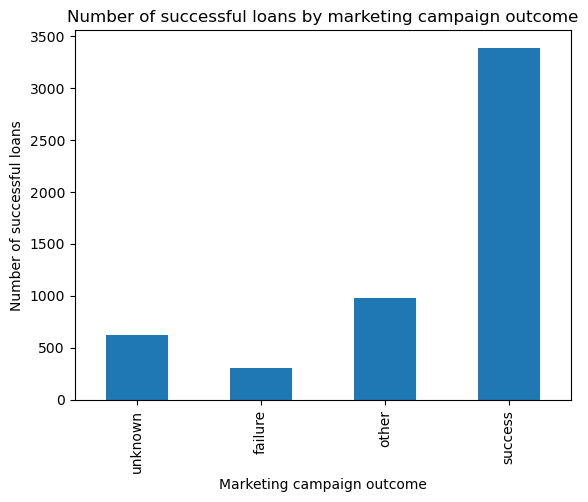

In [ ]:
#based on the above correlation matrix, there appears to be a correlation between the marketing campaign outcomes and the number of successful loans
#this simple plot show the count of successful loans by marketing campaign outcome
bank_clean.groupby('poutcome').sum()['y'].plot(kind='bar')
plt.xticks([0,1,2,3], ['unknown', 'failure', 'other', 'success'])
plt.title('Number of successful loans by marketing campaign outcome')
plt.xlabel('Marketing campaign outcome')
plt.ylabel('Number of successful loans')
plt.show()


#Combining marketing campaign data

I cleaned the data one step further by grouping any of the marketing data that was not success.  Unknown, failure and other became "failure or other".  After considering these results, I cleaned the original data one step further by making the Marketing campaign outcome boolean, success = 1, not successful =0.

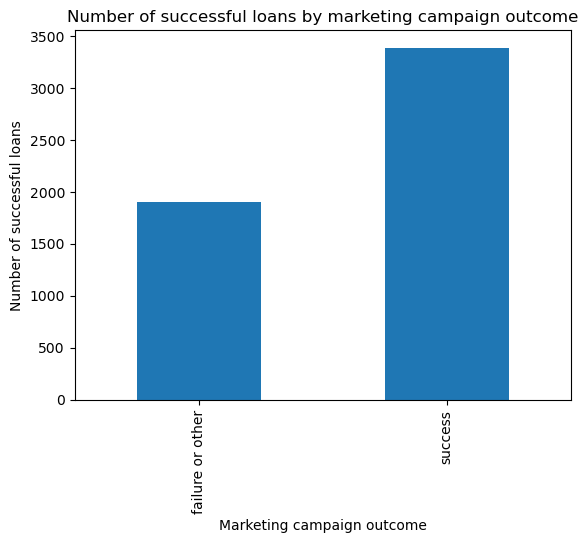

In [ ]:
#create the same bar chart but combine poutcomes with values of unknown, failire and other
bank_clean_grouped = bank_clean.copy()
#replace poutcome values of unknown, failure and other in bank_clean_grouped with "failure or other"
bank_clean_grouped['poutcome'] = bank_clean_grouped['poutcome'].replace([0, 1, 2], 1)
bank_clean_grouped.groupby('poutcome').sum()['y'].plot(kind='bar')
plt.xticks([0,1], ['failure or other', 'success'])
plt.title('Number of successful loans by marketing campaign outcome')
plt.xlabel('Marketing campaign outcome')
plt.ylabel('Number of successful loans')
plt.show()


In [ ]:
#replacing the poutcome values with boolean values, 1= success, 0= non a success
bank_clean['poutcome'] = bank_clean['poutcome'].replace([0, 1, 2], 0)
bank_clean['poutcome'] = bank_clean['poutcome'].replace(3, 1)
bank_clean.head()



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,1,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,1,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,1,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,1,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,1,0


In [ ]:
#repeating the process for the sample data
bank_clean_sample['poutcome'] = bank_clean_sample['poutcome'].replace([0, 1, 2], 0)
bank_clean_sample['poutcome'] = bank_clean_sample['poutcome'].replace(3, 1)
bank_clean_sample.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,-1,0,1,0
1,33,7,1,1,0,4789,1,1,0,11,8,220,1,339,4,0,0
2,35,4,2,2,0,1350,1,0,0,16,0,185,1,330,1,0,0
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,-1,0,1,0
4,59,1,1,1,0,0,1,0,2,5,8,226,1,-1,0,1,0


## KNN Classifier
The k-nearest neighbor algorithm looks for data with similar proximities for classifying.  In this instance, the KNN classifier will look at the values of each customer, if they accepted the terms of the loan (success), the algorithm will search for other customers with a similar data profile to classify or predict those who will accept the loan or not.

After testing the n_neighbor values, I used 13 and used the Euclidian metric for distance.  The KNN classifier was 89.2% accurate.

In [ ]:
#split the bank_clean data into train and test
X = bank_clean.drop('y', axis=1)
y = bank_clean['y']
X_train, X_test, y_train, y_test = train_test_split(X, y.astype(str), test_size=0.2, random_state=42)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [ ]:
# checking for ideal n_neighbors: section commented out because it takes a long time to run
# neighbors = np.arange(1, 30) 
# train_accuracy = np.empty(len(neighbors)) 
# test_accuracy = np.empty(len(neighbors)) 
  
# Loop over K values 
# for i, k in enumerate(neighbors): 
#     knn = KNeighborsClassifier(n_neighbors=k) 
#     knn.fit(X_train, y_train) 
      
#     # Compute training and test data accuracy 
#     train_accuracy[i] = knn.score(X_train, y_train) 
#     test_accuracy[i] = knn.score(X_test, y_test) 
  
# Generate plot 
# plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy') 
# plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')  
# plt.legend() 
# plt.xlabel('n_neighbors') 
# plt.ylabel('Accuracy') 
# plt.show() 

In [ ]:
# Setting up the KNN Classifier, p=2 sets the distance metric to Euclidean
classifier = KNeighborsClassifier(n_neighbors = 13, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

#creating the confusion matrix and accuracy score
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test,y_pred)

print('Confusion Matrix: \n', cm)
print('Accuracy Score: ', ac)

Confusion Matrix: 
 [[7776  176]
 [ 802  289]]
Accuracy Score:  0.891850049762247


In [ ]:
#create a visualization of the KNN classifier
#I struggled to change the labels on the key, the image in the notebook is Photoshopped
mesh_size = .02
margin = 0.25

# Load and split data
X, y = make_moons(noise=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y.astype(str), test_size=0.25, random_state=0)

# Create a mesh grid on which we will run our model
x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)
xx, yy = np.meshgrid(xrange, yrange)

# put classifier on a grid
classifier = KNeighborsClassifier(n_neighbors = 13, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

trace_specs = [
    [X_train, y_train, '0', 'Train', 'square'],
    [X_train, y_train, '1', 'Train', 'circle'],
    [X_test, y_test, '0', 'Test', 'square-dot'],
    [X_test, y_test, '1', 'Test', 'circle-dot']
]

fig = go.Figure(data=[
    go.Scatter(
        x=X[y==label, 0], y=X[y==label, 1],
        name=f'{split} Split, Label {label}',
        mode='markers', marker_symbol=marker
    )
    for X, y, label, split, marker in trace_specs
])

#add a title
fig.update_layout(title='KNN Classifier', height=800)


fig.update_traces(
    marker_size=12, marker_line_width=1.5,
    marker_color="lightyellow"
)

fig.add_trace(
    go.Contour(
        x=xrange,
        y=yrange,
        z=Z,
        showscale=False,
        colorscale='RdBu',
        opacity=0.4,
        name='Score',
        hoverinfo='skip'
    )
)
fig.show()

## Logistic regression

Logisitic regression classifies data into binary values:  yes the customer accepted the terms of the loan (1), or no, the customer did not accept the terms.  The features are analyzed to create trends in the data and a threshold is created.  The data will fall on either side of the probability line, in this case whether they accepted or did not accept the terms of the loan.

The logistic regression model was 88% accurate.

In [ ]:
#create a linear regression model
lgr = LogisticRegression(random_state=42, max_iter = 1000)

lgr.fit(X_test, y_test)
lgr_acc = lgr.score(X_test, y_test)

#create predictions
y_pred = lgr.predict(X_test)

print('Logistic Regression Model Accuracy: ', lgr_acc)


Logistic Regression Model Accuracy:  0.88


In [ ]:
#show the decision boundary of the logistic regression model
X, y = make_moons(noise=0.3, random_state=0)

# Create a mesh grid on which we will run our model
x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)
xx, yy = np.meshgrid(xrange, yrange)

# put classifier on a grid
classifier = LogisticRegression(random_state=42, max_iter = 1000)
classifier.fit(X_train, y_train)
Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

trace_specs = [
    [X_train, y_train, '0', 'Train', 'square'],
    [X_train, y_train, '1', 'Train', 'circle'],
    [X_test, y_test, '0', 'Test', 'square-dot'],
    [X_test, y_test, '1', 'Test', 'circle-dot']
]

fig = go.Figure(data=[
    go.Scatter(
        x=X[y==label, 0], y=X[y==label, 1],
        name=f'{split} Split, Label {label}',
        mode='markers', marker_symbol=marker
    )
    for X, y, label, split, marker in trace_specs
])

#add a title
fig.update_layout(title='Logistic Regression Model', height=800)

fig.update_traces(
    marker_size=12, marker_line_width=1.5,
    marker_color="lightyellow"
)

fig.add_trace(
    go.Contour(
        x=xrange,
        y=yrange,
        z=Z,
        showscale=False,
        colorscale='RdBu',
        opacity=0.4,
        name='Score',
        hoverinfo='skip'
    )
)
fig.show()




## Decision Trees

The decision tree classifier creates a branchin process to predict outcomes.  Each node in the tree specifies a test on an attribute and each branch descending from that node corresponds to one of the possible values for that attribute.  In this instance, the possible values will be the 'Y' outcome, whether the customer accepted the loan terms or not.

The decision tree classifier was 88% accurate.

In [ ]:
#create a decision tree classifier
dtc = DecisionTreeClassifier(random_state=42)

dtc.fit(X_train, y_train)
dtc_acc = dtc.score(X_test, y_test)
print('Decision Tree Classifier Accuracy: ', dtc_acc)

Decision Tree Classifier Accuracy:  0.88


In [ ]:
#visualize the decision tree boundary
X, y = make_moons(noise=0.3, random_state=0)

# Create a mesh grid on which we will run our model
x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)
xx, yy = np.meshgrid(xrange, yrange)

# put classifier on a grid
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)
Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

trace_specs = [
    [X_train, y_train, '0', 'Train', 'square'],
    [X_train, y_train, '1', 'Train', 'circle'],
    [X_test, y_test, '0', 'Test', 'square-dot'],
    [X_test, y_test, '1', 'Test', 'circle-dot']
]

fig = go.Figure(data=[
    go.Scatter(
        x=X[y==label, 0], y=X[y==label, 1],
        name=f'{split} Split, Label {label}',
        mode='markers', marker_symbol=marker
    )
    for X, y, label, split, marker in trace_specs
])

#add a title
fig.update_layout(title='Decision Tree Classifier', height=800)

fig.update_traces(
    marker_size=12, marker_line_width=1.5,
    marker_color="lightyellow"
)

fig.add_trace(
    go.Contour(
        x=xrange,
        y=yrange,
        z=Z,
        showscale=False,
        colorscale='RdBu',
        opacity=0.4,
        name='Score',
        hoverinfo='skip'
    )
)
fig.show()

## Support Vector Machines

SVC works best for small, complex datasets.  The original bank data was sampled to create a manageable data set for SVC analysis.  SVC is based on vectors and uses dot-product calculations to classify the data.  SVC was tested using a variety of kernals (linear, poly, and guassian); linear performed the best.

The support vector classifier (using the linear kernel) was 89.1% accurate.

In [ ]:
#setting up the SVC
#using the sample data for this classifier to compensate for the heavy computational load
#split the bank_clean data into train and test
X = bank_clean_sample.drop('y', axis=1)
y = bank_clean_sample['y']
X_train, X_test, y_train, y_test = train_test_split(X, y.astype(str), test_size=0.2, random_state=42)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)


In [ ]:
svc = SVC(kernel = 'linear', gamma=2).fit(X_train, y_train)
svc_acc = svc.score(X_test, y_test)

#create predictions
y_pred = svc.predict(X_test)

print('Support Vector Accuracy: ', svc_acc)

Support Vector Accuracy:  0.8917127071823204


In [ ]:
#I welcome suggestions on how to make a visualization of the SVC decision boundary.  I got stuck and it's late...
#An additional note, upon discussing converting the categorical data into numeric values, it was suggested that I use OneHotEncoder instead of LabelEncoder, 
#as the LabelEncoder implies an order to the data that may not exist.   

#I plan to research this further in the future.

